# Reconstructing cat states with a single shot

We reconstruct the density matrix of the family of bosonic `cat` codes with a
single evaluation of a pre-trained CGAN. The definition of the `cat` states is
taken from [Albert et al., 2018](https://www.doi.org/10.1103/PhysRevA.97.032346).


In [1]:
import numpy as np

from qutip import expect, displace, fock_dm, coherent, coherent_dm, fidelity, rand_dm
from qutip.wigner import wigner
from qutip.visualization import plot_wigner_fock_distribution, plot_wigner


import tensorflow as tf
import tensorflow_addons as tfa


from tqdm.auto import tqdm

from qst_cgan.ops import convert_to_real_ops, batched_expect, tf_fidelity, dm_to_tf, convert_to_complex_ops, tf_to_dm
from qst_cgan.gan import generator_loss, discriminator_loss, Generator, Discriminator, DensityMatrix, Expectation


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from dataclasses import dataclass

import os

%load_ext autoreload
tf.keras.backend.set_floatx('float64')
os.environ["CUDA_VISIBLE_DEVICES"] = ""

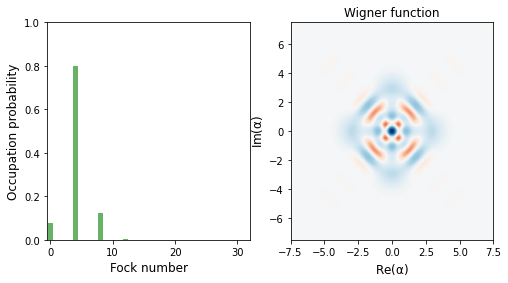

In [2]:
hilbert_size = 32

def cat(N, alpha, S=None, mu=None):
    """
    Generates a cat state. For a detailed discussion on the definition
    see `Albert, Victor V. et al. “Performance and Structure of Single-Mode Bosonic Codes.” Physical Review A 97.3 (2018) <https://arxiv.org/abs/1708.05010>`_
    and `Ahmed, Shahnawaz et al., “Classification and reconstruction of quantum states with neural networks.” Journal <https://arxiv.org/abs/1708.05010>`_
    
    Args:
    -----
        N (int): Hilbert size dimension.
        alpha (complex64): Complex number determining the amplitude.
        S (int): An integer >= 0 determining the number of coherent states used
                 to generate the cat superposition. S = {0, 1, 2, ...}.
                 corresponds to {2, 4, 6, ...} coherent state superpositions.
        mu (int): An integer 0/1 which generates the logical 0/1 encoding of 
                  a computational state for the cat state.


    Returns:
    -------
        cat (:class:`qutip.Qobj`): Cat state density matrix
    """
    if S == None:
        S = 0

    if mu is None:
        mu = 0

    kend = 2 * S + 1
    cstates = 0 * (coherent(N, 0))

    for k in range(0, int((kend + 1) / 2)):
        sign = 1

        if k >= S:
            sign = (-1) ** int(mu > 0.5)

        prefactor = np.exp(1j * (np.pi / (S + 1)) * k)

        cstates += sign * coherent(N, prefactor * alpha * (-((1j) ** mu)))
        cstates += sign * coherent(N, -prefactor * alpha * (-((1j) ** mu)))

    rho = cstates * cstates.dag()
    return rho.unit()


rho = cat(hilbert_size, 2, 1, mu=0)
plot_wigner_fock_distribution(rho)
plt.show()

# Construct the measurement operators


In [3]:
def husimi_op(hilbert_size: int, beta: complex):
    """Computes the operator for a Wigner function measurement

    Args:
        hilbert_size (int): Hilbert size dimension
        beta (complex): Phase space point
    """
    return coherent_dm(hilbert_size, beta)

xvec = np.linspace(-7.5, 7.5, 32)
yvec = np.linspace(-7.5, 7.5, 32)

X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()
m_ops = [husimi_op(hilbert_size, beta) for beta in betas]

# Setup the inputs to the neural network - measurement ops and data

We need to convert the QuTiP qunatum objects to TensorFlow objects in order to feed them to the neural network.
We take 1024 operators (32 x 32 grid of complex $\beta$ values in the phase space). Each operator is a complex matrix
of size 32 x 32 since we choose a Hilbert space cutoff of 32. Since for each state we are measuring the same operators,
we repeat them for the number of states in each batch, i.e., `batch_size`.

Once we convert the measurement operators to a TensorFlow complex tensor, we further separate the real and imaginary parts.
The measurement operators are therefore input as real matrix with the last dimension as (`2 x ` number of operators).
We have 1024 operators with a batch size of 16 and therefore the input to the neural networks is a
$16 \times  32 \times 32  \times 2048$ dimensional tensor containing the real and imaginary parts of the all
the complex-valued measurement operators.

The other input is the data itself as a $16 \times 1024$ tensor.

In [4]:
batch_size = 16 # generate 16 states in each round

ops = dm_to_tf(m_ops)
ops_batch = tf.convert_to_tensor([ops for i in range(batch_size)])
A = convert_to_real_ops(ops_batch)

# Training the Conditional Generative Adversarial Network (CGAN)

We construct a `Generator` and a `Discriminator` using TensorFlow and train them for state reconstruction in an adversarial fashion. The inputs to the CGAN are the data (`x`) and the measurement operators converted as real matrices `A`. We also construct a `model_dm` that shares weights with the generator to predict the density matrix of the state.

In [5]:
num_measurements = 32*32
generator = Generator(hilbert_size, num_measurements, noise=0.)
discriminator = Discriminator(hilbert_size, num_measurements)

# If you have saved checkpoints of the models from before then load as
try:
    generator.load_weights("models/ckpt-generator")
    discriminator.load_weights("models/ckpt-discriminator")
except:
    pass

In [6]:
density_layer_idx = None

for i, layer in enumerate(generator.layers): 
    if "density_matrix" in layer._name:
        density_layer_idx = i
        break

model_dm = tf.keras.Model(inputs=generator.input,
                          outputs=generator.layers[density_layer_idx].output)

# Let us make a prediction on a set of randomly generated states

In [7]:
def random_alpha(radius: float, inner_radius=0):
    """
    Generates a random complex value within a circle.

    Args:
        radius (float): Radius of the phase space
        inner_radius (int, optional): [description]. Inner radius.
                                                     Defaults to 0

    Returns:
        complex: A complex value.
    """
    radius = np.random.uniform(inner_radius, radius)
    phi = np.random.uniform(-np.pi, np.pi)
    return radius * np.exp(1j * phi)


def generate_batch(batch_size: int):
    """Generates a batch of random cat state density matrices

    Args:
        batch_size (int): Batch size

    Yields:
        [list of Qobj]: A list of density matrices
    """
    rhos = []

    for i in range(batch_size):
        alpha = random_alpha(1, 3)
        
        S = np.random.randint(0, 4)
        rho = cat(hilbert_size, alpha=alpha, S=S)
        rhos.append(rho)

    yield rhos

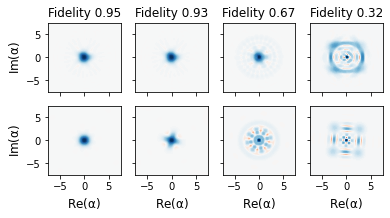

In [8]:
def show_comparision(predicted_rho:list, rho_true:list):
    """Plot a comparision between predictions and true density matrices

    Args:
        predicted_rho (list): List of predicted density matrices
        rho_true (list): True density matrix.
    """
    num_examples = len(predicted_rho)

    fig, grid = plt.subplots(2, num_examples,
                  figsize=((6/4)*num_examples, 2.8), sharex=True, sharey=True)

    for i in range(num_examples):
        plot_wigner(pred_dm[i], ax=grid[0, i])
        plot_wigner(rho_true[i], ax=grid[1, i])

        grid[0, i].set_title("Fidelity {:.2f}".format(fidelity(rho_true[i], pred_dm[i])))
        
        if i > 0:
            grid[0, i].set_ylabel("")
            grid[0, i].set_xlabel("")
        grid[0, 0].set_xlabel("")            
        if i > 0:
            grid[1, i].set_ylabel("")
            grid[1, i].set_title("")
        grid[1, 0].set_title("")
    plt.show()


for rhos in generate_batch(batch_size):
    rho_tf = dm_to_tf(rhos)
    x = batched_expect(ops_batch, rho_tf)
    pred_dm = tf_to_dm(model_dm([A, x]))

show_comparision(pred_dm[:4], rhos[:4])

# Training

We train the networks using TensorFlow optimizers and record the loss function as well as intermediate density matrices during training. In order to get the intermediate density matrices, we construct a `density matrix` model called `model_dm` model that outputs the density matrix using the generator.

In [9]:
@dataclass
class LossHistory:
    """Class for keeping track of loss"""
    generator: list
    discriminator: list
    l1: list

loss = LossHistory([], [], [])
fidelities = []

In [10]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.0002,
                                                             decay_steps=10000,
                                                             decay_rate=0.96,
                                                             staircase=False)


generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule, 0.5, 0.5)

lam = 100.

# Reconstruction using QST-CGAN

Note that we are comparing fidelity to the ideal state which is clearly going 
to be rather poor sin

In [15]:
def train_step(A, x):
    """Takes one step of training for the full A matrix representing the
    measurement operators and data x.

    Note that the `generator`, `discriminator`, `generator_optimizer` and the
    `discriminator_optimizer` has to be defined before calling this function.

    Args:
        A (tf.Tensor): A tensor of shape (m, hilbert_size, hilbert_size, n x 2)
                       where m=1 for a single reconstruction, and n represents
                       the number of measured operators. We split the complex
                       operators as real and imaginary in the last axis. The 
                       helper function `convert_to_real_ops` can be used to
                       generate the matrix A with a set of complex operators
                       given by `ops` with shape (1, n, hilbert_size, hilbert_size)
                       by calling `A = convert_to_real_ops(ops)`.

        x (tf.Tensor): A tensor of shape (m, n) with m=1 for a single
                       reconstruction and `n` representing the number of
                       measurements. 
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([A, x], training=True)

        disc_real_output = discriminator([A, x, x], training=True)
        disc_generated_output = discriminator([A, x, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, x,
            lam=lam)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    slopes = tf.convert_to_tensor([tf.sqrt(tf.reduce_sum(s**2)) for s in discriminator_gradients])
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([A, x], training=True)

        disc_real_output = discriminator([A, x, x], training=True)
        disc_generated_output = discriminator([A, x, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, x,
            lam=lam)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output) + 100*gradient_penalty

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    loss.generator.append(gen_gan_loss)
    loss.l1.append(gen_l1_loss)
    loss.discriminator.append(disc_loss)

max_iterations = 10000
pbar = tqdm(range(max_iterations))
log_interval = 10

for i in pbar:
    for rhos in generate_batch(batch_size):
        rho_tf = dm_to_tf(rhos)
        x = batched_expect(ops_batch, rho_tf)
        train_step(A, x)

    if i % log_interval == 0:
        generator.save_weights("models/ckpt-generator")
        discriminator.save_weights("models/ckpt-discriminator")

  0%|          | 40/10000 [02:02<8:28:26,  3.06s/it]


KeyboardInterrupt: 

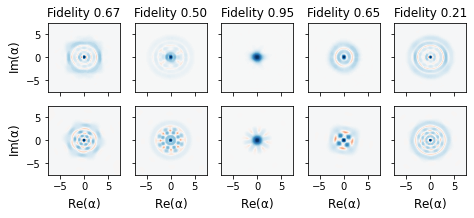

In [16]:
generator.load_weights("models/ckpt-generator")
discriminator.load_weights("models/ckpt-discriminator")

model_dm = tf.keras.Model(inputs=generator.input,
                          outputs=generator.layers[density_layer_idx].output)

for rhos in generate_batch(batch_size):
    rho_tf = dm_to_tf(rhos)
    x = batched_expect(ops_batch, rho_tf)
    pred_dm = tf_to_dm(model_dm([A, x]))

show_comparision(pred_dm[:5], rhos[:5])

# Predict states for a large number of random cat states

In [19]:
f_values = []

for i in tqdm(range(100)):
    for rhos in generate_batch(batch_size):
        rho_tf = dm_to_tf(rhos)
        x = batched_expect(ops_batch, rho_tf)
        pred_dm = tf_to_dm(model_dm([A, x]))

        for i in range(len(pred_dm)):
            f_values.append(fidelity(pred_dm[i], rhos[i]))

100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Predicted density matrices for 1600 states


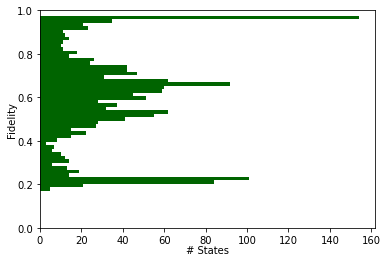

In [23]:
print("Predicted density matrices for {} states".format(len(f_values)))
plt.hist(f_values,
             bins=50, color="darkgreen",
             orientation='horizontal')
plt.ylim(0, 1)
plt.ylabel("Fidelity", labelpad = -0.1)
plt.xlabel("# States", labelpad = -0.1)
plt.show()